### Классификация по тональности
В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

[Материалы](https://github.com/netology-ds-team/nlp-homeworks/tree/main/3_Thematic_modeling/Materials)

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.

Тексты хранятся в json-ах в массиве responses.

Посмотрим на примере отзыва: возьмите для удобства ноутбук, размещенный в папке репозитория.


### Часть 1. Анализ текстов
1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
- слов
- слов без стоп-слов
- лемм
- существительных

4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
- какое слово встречается чаще, "сотрудник" или "клиент"?
- сколько раз встречается слова "мошенничество" и "доверие"?

6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

### Часть 2. Тематическое моделирование
1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?
Эта часть задания может быть сделана с использованием gensim.

### Часть 3. Классификация текстов
Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам.
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
- 1-ый вариант: $tf-idf$ преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
- 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).
Используйте accuracy и F-measure для оценки качества классификации.

В ноутбуке, размещенном в папке репозитория. написан примерный Pipeline для классификации текстов.

Эта часть задания может быть сделана с использованием sklearn.

In [ ]:
import json
import bz2
import regex
from tqdm import tqdm
from scipy import sparse
import re
import time
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Загрузка данных

In [ ]:
responses = []
with bz2.BZ2File('/content/drive/MyDrive/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [02:56, 1136.57it/s]



Посмотрим на пример отзыва:

In [ ]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

In [ ]:
data = pd.DataFrame.from_dict(responses)

In [ ]:
# создание датафрейма из списка словарей
df = pd.DataFrame.from_dict(responses)

In [ ]:
df

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN
...,...,...,...,...,...,...,...,...,...,...
153494,None,False,Не все так страшно,0,лицензия № 2557,Вера,Ситибанк,2005-05-18 14:38:00,"Слишком большой банк, не всегда учитывает нашу...",5.0
153495,None,False,А вы договор читали?,0,лицензия № 2557,Kirill,Ситибанк,2005-04-14 15:25:00,"Вы сами виноваты в своих проблемах, кроме пред...",3.0
153496,None,False,"Филиал банка ""ОВК"" в г. Иваново",1,лицензия № 2272,AlexU-post,Росбанк,2005-04-08 14:07:00,Уважаемое руководство банка «ОВК»! Я проживаю ...,1.0
153497,None,False,В Альфа-Банк больше обращаться не буду.,0,лицензия № 1326,Ирина,Альфа-Банк,2005-04-14 15:16:00,Пробовала 10.04.05 оформить товар в кредит в А...,1.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


## Часть 1. Анализ текстов


    1. Посчитайте количество отзывов в разных городах и на разные банки
    2. Постройте гистограмы длин слов в символах и в словах
    3. Найдите 10 самых частых:
        * слов
        * слов без стоп-слов
        * лемм
        * существительных
    4. Постройте кривые Ципфа и Хипса
    5. Ответьте на следующие вопросы:
        * какое слово встречается чаще, "сотрудник" или "клиент"?
        * сколько раз встречается слова "мошенничество" и "доверие"?
    6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [ ]:
df['city'].unique()

array(['г. Москва', 'г. Новосибирск', 'г. Ставрополь', ...,
       'г. Москва-Владимир', 'г. СПб.',
       'г. Краснодарский край, ст.Павловская'], dtype=object)

In [ ]:
df['city'].value_counts()

г. Москва                               55354
г. Санкт-Петербург                      14342
г. Екатеринбург                          2337
г. Новосибирск                           2300
г. Нижний Новгород                       1976
                                        ...  
г. г.Калуга                                 1
г. ВЕЛИКИЕ ЛУКИ                             1
г. всеволожск                               1
г. сейчас                                   1
г. Краснодарский край, ст.Павловская        1
Name: city, Length: 5823, dtype: int64

In [ ]:
df['city']

0              г. Москва
1         г. Новосибирск
2              г. Москва
3          г. Ставрополь
4           г. Челябинск
               ...      
153494              None
153495              None
153496              None
153497              None
153498              None
Name: city, Length: 153499, dtype: object

In [ ]:
df['city'][199]

'г. Краснодарский край Новокубанский район город Новокубанск'

In [ ]:
city_n = re.compile('г\. \w+\s\w+|г\. \w+')
tqdm.pandas()

# функция для обработки города
def city_normalization(city):
    # row = city.strip().lower().replace('-','_').replace('город', 'г. ').replace('СПБ', 'г. Неизвестный')
    row = city.replace('г. СПБ', 'г. Санкт-Петербург').replace('None', 'г. не_указан').replace('-','_').strip().lower()
    if len(city_n.findall(row))>0:
        return city_n.findall(row)[0]
    else:
        return city_n.findall(row)

df['city'] = df.city.astype('str').progress_apply(city_normalization)

100%|██████████| 153499/153499 [00:00<00:00, 278913.92it/s]


In [ ]:
df

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN
...,...,...,...,...,...,...,...,...,...,...
153494,г. не_указан,False,Не все так страшно,0,лицензия № 2557,Вера,Ситибанк,2005-05-18 14:38:00,"Слишком большой банк, не всегда учитывает нашу...",5.0
153495,г. не_указан,False,А вы договор читали?,0,лицензия № 2557,Kirill,Ситибанк,2005-04-14 15:25:00,"Вы сами виноваты в своих проблемах, кроме пред...",3.0
153496,г. не_указан,False,"Филиал банка ""ОВК"" в г. Иваново",1,лицензия № 2272,AlexU-post,Росбанк,2005-04-08 14:07:00,Уважаемое руководство банка «ОВК»! Я проживаю ...,1.0
153497,г. не_указан,False,В Альфа-Банк больше обращаться не буду.,0,лицензия № 1326,Ирина,Альфа-Банк,2005-04-14 15:16:00,Пробовала 10.04.05 оформить товар в кредит в А...,1.0


In [ ]:
df['city'].value_counts()

г. москва                     57042
г. неизвестный                15174
г. санкт_петербург            14818
г. екатеринбург                2391
г. новосибирск                 2387
                              ...  
г. туапсе_краснодар_ростов        1
г. будённовск                     1
г. санкт_петеурбрг                1
г. voronezh                       1
г. москва_владимир                1
Name: city, Length: 2941, dtype: int64

#### 1. Посчитайте количество отзывов в разных городах и на разные банки

In [ ]:
# Посчитайте количество отзывов в разных городах и на разные банки
df['city'] = df.city.astype('str')
# группировка
feedback = df.filter(items = ['city', 'bank_name', 'text']).groupby(['city', 'bank_name']).count().sort_values(by = 'text', ascending=False)
feedback.head(20)

text
city               bank_name                      
г. москва          Сбербанк России            8378
                   Альфа-Банк                 3995
                   Русский Стандарт           2919
                   ВТБ 24                     2770
г. санкт_петербург Сбербанк России            2525
г. москва          Московский Кредитный Банк  2414
                   Тинькофф Банк              2395
                   Хоум Кредит Банк           2199
                   Национальный Банк «Траст»  1710
                   Райффайзенбанк             1468
                   Связной Банк               1465
                   Банк Москвы                1326
                   Ренессанс Кредит           1270
                   ЮниКредит Банк             1201
г. не_указан       Альфа-Банк                 1165
г. москва          Ситибанк                   1151
                   Промсвязьбанк              1114
                   Авангард                   1097
г. не_указан       Ситибанк                   1047
г. санкт_петербург ВТБ 24                      961

<Axes: title={'center': 'Распределение кол-ва отзывов Город - Банк'}, xlabel='Город / Банк', ylabel='Количество'>

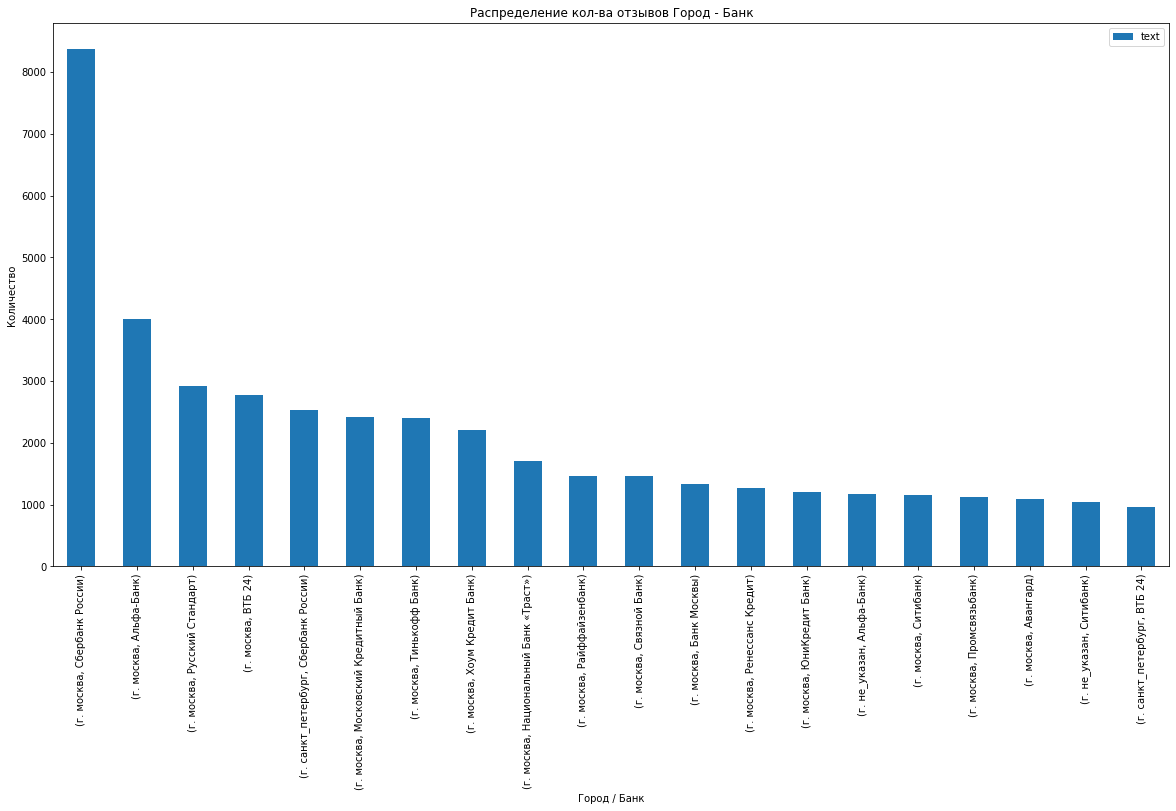

In [ ]:
# столбчатая диаграмма показывает количество отзывов для банка из определенного города
feedback.iloc[:20].plot(kind='bar', figsize = (20, 10),
                     title='Распределение кол-ва отзывов Город - Банк',
                     xlabel='Город / Банк',
                     ylabel='Количество')

#### 2. Постройте гистограмы длин текстов в символах и в словах

In [ ]:
# rating_grade df.rating_grade.unique()

array([nan,  2.,  1.,  5.,  3.,  4.])

In [ ]:
df.rating_grade.value_counts()

1.0    47387
5.0    14713
2.0    13509
3.0     9261
4.0     3788
Name: rating_grade, dtype: int64

In [ ]:
# количество пропусков в рейтинге
len(df)-df.rating_grade.value_counts().sum()

64841

In [ ]:
# замена пропусков модой
df['rating_grade'] = df['rating_grade'].fillna(df['rating_grade'].mode()[0])

In [ ]:
df.rating_grade.value_counts()

1.0    112228
5.0     14713
2.0     13509
3.0      9261
4.0      3788
Name: rating_grade, dtype: int64

In [ ]:
# Оставим 1000 строк и столбцы с отзывами и рейтингом
df = df[['title', 'text', 'rating_grade']].sample(1000)
df.head()

,title,text,rating_grade
30080,Злоключения со Сбербанком,К моему несчастью у меня в Сбербанке зарплатна...,1.0
62030,Счет,"Открыла счет в банке, подключено автоследовани...",1.0
21054,Пытки при получении ваших денег,Здравствуйте всем! Сегодня закрывал вклад в СП...,3.0
95179,Перевыпуск карты после хизщения денег,Спасибо Сбербанку - оперативно и быстро рассмо...,1.0
144774,Обслуживание становится хуже...,Живу в Таганроге. Создал недавно свою фирму и ...,1.0


In [ ]:
len(df.title.unique())

964

In [ ]:
! pip install pymorphy2
import pymorphy2

m = pymorphy2.MorphAnalyzer()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords

In [ ]:
# функции для препроцессинга тесктов

mystopwords = stopwords.words('russian') + [
    'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д',
    'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой'
]
ru_words = re.compile("[А-Яа-я]+")

def words_only(text):
    return " ".join(ru_words.findall(text))


def lemmatize(text):
    try:
        return  " ".join([m.parse(w)[0].normal_form for w in text.lower().split()])
    except:
        return " "


def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""


def preprocess(text):
    return remove_stopwords(lemmatize(words_only(text.lower())))

In [ ]:
df.text = df.text.astype('str').progress_apply(preprocess)
df.title = df.title.astype('str').progress_apply(preprocess)

100%|██████████| 1000/1000 [00:01<00:00, 796.98it/s]


In [ ]:
df.text

30080     несчастие сбербанк зарплатный карта вчера октя...
62030     открыть счёт банк подключить автоследование об...
21054     здравствуйте весь сегодня закрывать вклад спб ...
95179     спасибо сбербанк оперативно быстро рассмотреть...
144774    жить таганрог создать недавно фирма решить пой...
                                ...                        
115028    день окончание срок депозит решить позвонить з...
126062    ужас читать последний отзыв альф думать пнуть ...
144008    искать банк завести пластиковый карта снова ви...
1223      прийти письмо счастие договор ответить дорога ...
126053    госпожа зиновьев перечислить список документ в...
Name: text, Length: 1000, dtype: object

In [ ]:
# сделаем токенизацию слов по текстам с помощью split
len(df.text[30080].split())

129

In [ ]:
len(df.text[30080].replace(' ', ''))

936

In [ ]:
df = df.drop(columns = 'len_text')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 30080 to 126053
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         1000 non-null   object 
 1   text          1000 non-null   object 
 2   rating_grade  1000 non-null   float64
 3   len_text_w    1000 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 71.4+ KB


In [ ]:
df['len_text_w'] = 0
df['len_text_s'] = 0

In [ ]:
# количество слов в тексте
df.len_text_w = df.text.astype('str').progress_apply(lambda text : len(text.split()))

100%|██████████| 1000/1000 [00:00<00:00, 13479.83it/s]


In [ ]:
# количество символов без пробелов
df.len_text_s =  df.text.astype('str').progress_apply(lambda text : len(text.replace(' ', '')))

100%|██████████| 1000/1000 [00:00<00:00, 25310.80it/s]


In [ ]:
df

,title,text,rating_grade,len_text_w,len_text_s
30080,злоключение сбербанк,несчастие сбербанк зарплатный карта вчера октя...,1.0,129,936
62030,счёт,открыть счёт банк подключить автоследование об...,1.0,39,282
21054,пытка получение ваш деньга,здравствуйте весь сегодня закрывать вклад спб ...,3.0,149,987
95179,перевыпуск карта хизщение деньга,спасибо сбербанк оперативно быстро рассмотреть...,1.0,89,655
144774,обслуживание становиться плохой,жить таганрог создать недавно фирма решить пой...,1.0,147,966
...,...,...,...,...,...
115028,неквалифицированный обслуживание юниаструма банк,день окончание срок депозит решить позвонить з...,1.0,160,1133
126062,путный продукт,ужас читать последний отзыв альф думать пнуть ...,1.0,129,880
144008,лидер народный рейтинг,искать банк завести пластиковый карта снова ви...,1.0,208,1441
1223,простить друг прощать,прийти письмо счастие договор ответить дорога ...,1.0,82,545


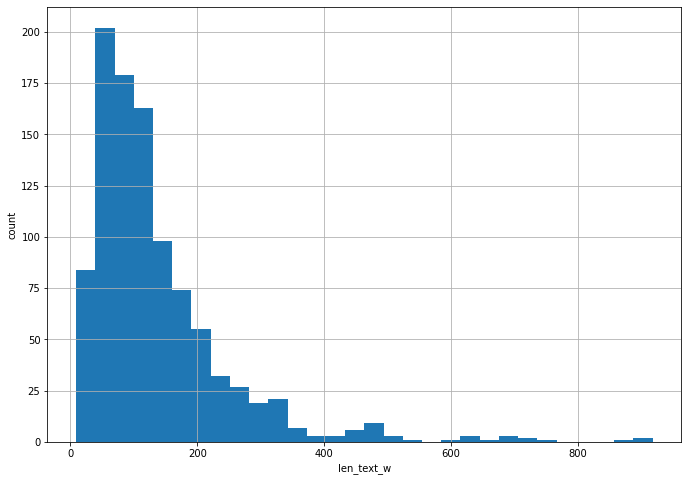

In [ ]:
plt.figure(figsize = (25, 8))

plt.subplot(121)
df['len_text_w'].hist(density=False, bins=30)
plt.ylabel('count')
plt.xlabel('len_text_w')

plt.show()

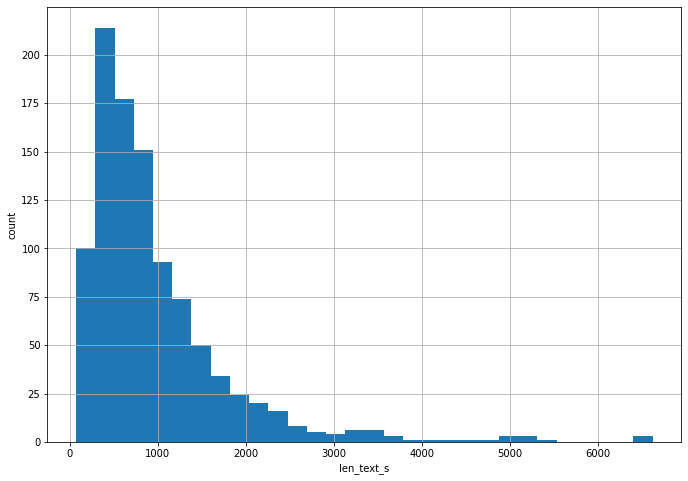

In [ ]:
plt.figure(figsize = (25, 8))

plt.subplot(121)
df['len_text_s'].hist(density=False, bins=30)
# plt.xticks()
plt.ylabel('count')
plt.xlabel('len_text_s')

plt.show()

#### Найдите 10 самых частых:
* слов
* слов без стоп-слов
* лемм
* cуществительных


In [ ]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
from nltk.probability import FreqDist

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
tqdm.pandas()

In [ ]:
data.text

0         Добрый день! Я не являюсь клиентом банка и пор...
1         Доброго дня! Являюсь держателем зарплатной кар...
2         Здравствуйте!  Дублирую свое заявление от 03.0...
3         Добрый день!! Я открыл расчетный счет в СберБа...
4         04.03.2015 г. взяла кредит в вашем банке, заяв...
                                ...                        
153494    Слишком большой банк, не всегда учитывает нашу...
153495    Вы сами виноваты в своих проблемах, кроме пред...
153496    Уважаемое руководство банка «ОВК»! Я проживаю ...
153497    Пробовала 10.04.05 оформить товар в кредит в А...
153498    Если коротко, то мне нравится. Кридит получать...
Name: text, Length: 153499, dtype: object

In [ ]:
акщь ыекштп шьзщке згтсегфешщт
згтсегфешщт

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# токенизация всего текста
corpus = [token.lower() for text in data.text for token in word_tokenize(text) if token not in punctuation]
# corpus = [token.lower() for token in ]
print(len(corpus))
corpus[:10]

36766261


['добрый',
 'день',
 'я',
 'не',
 'являюсь',
 'клиентом',
 'банка',
 'и',
 'поручителем',
 'по']

In [ ]:
# 10 самых частых слов
fdist_t = FreqDist(corpus)
fdist_t.most_common(10)

[('в', 1322516),
 ('и', 1054485),
 ('не', 851742),
 ('на', 704396),
 ('что', 621783),
 ('я', 573896),
 ('с', 454545),
 ('по', 365188),
 ('мне', 320695),
 ('банка', 263957)]

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Удаление  стоп-слов

mystopwords = stopwords.words('russian') + [
    'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д',
    'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой', '...', '``', '\'\''
]

def remove_stopwords(text, mystopwords = mystopwords):
    try:
        text
        return [token for token in text if not token in mystopwords]
    except:
        return ""

In [ ]:
corpus_stop = remove_stopwords(corpus)

In [ ]:
print(len(corpus_stop))
corpus_stop[:10]

23194639


['добрый',
 'день',
 'являюсь',
 'клиентом',
 'банка',
 'поручителем',
 'кредитному',
 'договору',
 'являюсь',
 'каким-либо']

In [ ]:
# 10 самых частых слов без стоп слов
fdist_s = FreqDist(corpus_stop)
fdist_s.most_common(10)

[('банка', 263957),
 ('банк', 196303),
 ('деньги', 130062),
 ('карту', 104947),
 ('карты', 100877),
 ('кредит', 80282),
 ('день', 75996),
 ('заявление', 69524),
 ('отделение', 66468),
 ('очень', 66174)]

In [ ]:
# лемматизация
! pip install pymorphy2
import pymorphy2

m = pymorphy2.MorphAnalyzer()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 51.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13721 sha256=074b6533ac18a597b22bc6de677fbac57b332f0c4092ea971c3593c61dbc4937
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt


In [ ]:
def lemmatize(text):
    try:
        return  [m.parse(w)[0].normal_form for w in text]
    except:
        return " "

In [ ]:
corpus_lemm = lemmatize(corpus_stop)
print(len(corpus_lemm))
corpus_lemm[:10]

23194639


['добрый',
 'день',
 'являться',
 'клиент',
 'банк',
 'поручитель',
 'кредитный',
 'договор',
 'являться',
 'какой-либо']

In [ ]:
# 10 самых частых лeмм
fdist_l = FreqDist(corpus_lemm)
fdist_l.most_common(10)

[('банк', 624272),
 ('карта', 331815),
 ('деньга', 178338),
 ('день', 172634),
 ('мой', 167035),
 ('кредит', 154865),
 ('отделение', 143616),
 ('счёт', 140509),
 ('сотрудник', 133662),
 ('клиент', 132908)]

In [ ]:
# нахождение существительных
def noun(text):
    try:
        # return  [m.parse(w)[0].tag.POS == 'NOUN' for w in text]
        return [w for w in text if m.parse(w)[0].tag.POS == 'NOUN']
    except:
        return " "

In [ ]:
corpus_noun = noun(corpus_lemm)
print(len(corpus_noun))
corpus_noun[:10]

10478954


['день',
 'клиент',
 'банк',
 'поручитель',
 'договор',
 'лицо',
 'отношение',
 'банк',
 'повод',
 'урегулирование']

In [ ]:
# 10 самых частых существительных
fdist_n = FreqDist(corpus_noun)
fdist_n.most_common(10)

In [ ]:
fdist_t.most_common(10)[0][0]

##### Результирующий датасет по частотности

In [ ]:
# Результирующий датасет по частотности
result_df = pd.DataFrame({
    'frequent_word': [fdist_t.most_common(10)[0][0],
                      fdist_t.most_common(10)[1][0],
                      fdist_t.most_common(10)[2][0],
                      fdist_t.most_common(10)[3][0],
                      fdist_t.most_common(10)[4][0],
                      fdist_t.most_common(10)[4][0],
                      fdist_t.most_common(10)[6][0],
                      fdist_t.most_common(10)[7][0],
                      fdist_t.most_common(10)[8][0],
                      fdist_t.most_common(10)[9][0]],
    'frequent_stop': [fdist_s.most_common(10)[0][0],
                      fdist_s.most_common(10)[1][0],
                      fdist_s.most_common(10)[2][0],
                      fdist_s.most_common(10)[3][0],
                      fdist_s.most_common(10)[4][0],
                      fdist_s.most_common(10)[4][0],
                      fdist_s.most_common(10)[6][0],
                      fdist_s.most_common(10)[7][0],
                      fdist_s.most_common(10)[8][0],
                      fdist_s.most_common(10)[9][0]],
    'frequent_lemm': [fdist_l.most_common(10)[0][0],
                      fdist_l.most_common(10)[1][0],
                      fdist_l.most_common(10)[2][0],
                      fdist_l.most_common(10)[3][0],
                      fdist_l.most_common(10)[4][0],
                      fdist_l.most_common(10)[4][0],
                      fdist_l.most_common(10)[6][0],
                      fdist_l.most_common(10)[7][0],
                      fdist_l.most_common(10)[8][0],
                      fdist_l.most_common(10)[9][0]],
    'frequent_noun': [fdist_n.most_common(10)[0][0],
                      fdist_n.most_common(10)[1][0],
                      fdist_n.most_common(10)[2][0],
                      fdist_n.most_common(10)[3][0],
                      fdist_n.most_common(10)[4][0],
                      fdist_n.most_common(10)[4][0],
                      fdist_n.most_common(10)[6][0],
                      fdist_n.most_common(10)[7][0],
                      fdist_n.most_common(10)[8][0],
                      fdist_n.most_common(10)[9][0]]
}, index=None)

result_df

,frequent_word,frequent_stop,frequent_lemm,frequent_noun
0,в,банка,банк,банк
1,и,банк,карта,карта
2,не,деньги,деньга,деньга
3,на,карту,день,день
4,что,карты,мой,кредит
5,что,карты,мой,кредит
6,с,день,отделение,счёт
7,по,заявление,счёт,сотрудник
8,мне,отделение,сотрудник,клиент
9,банка,очень,клиент,сумма


#### Постройте кривые Ципфа и Хипса

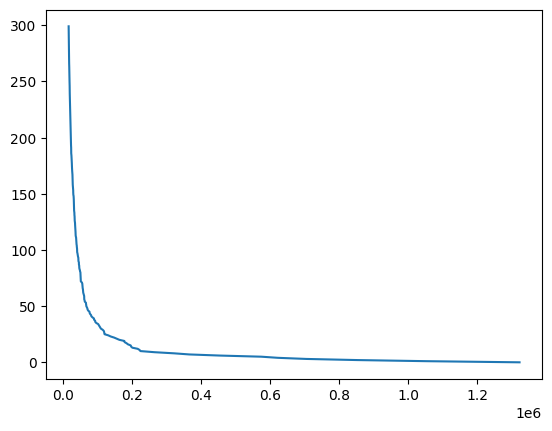

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

freqs = list(fdist_t.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

In [ ]:
from collections import Counter

In [ ]:
from tqdm import tqdm

cnt = Counter()
n_words = []
n_tokens = []
tokens = []
for index, row in tqdm(data.iterrows(), total = len(data)):
    tokens = word_tokenize(row['text'])
    cnt.update([token for token in tokens if token not in punctuation])
    n_words.append(len(cnt))
    n_tokens.append(sum(cnt.values()))

100%|██████████| 153499/153499 [09:04<00:00, 281.71it/s]


In [ ]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_words)
plt.show()

#### Ответьте на следующие вопросы:

  * какое слово встречается чаще, "сотрудник" или "клиент"?
  * сколько раз встречается слова "мошенничество" и "доверие"?


In [ ]:
if  fdist_l.freq('сотрудник') > fdist_l.freq('клиент'):
    print('Слово сотрудник встречается чаще, чем слово клиент')
else:
    print('Слово клиент встречается чаще, чем слово сотрудник')


Слово сотрудник встречается чаще, чем слово клиент


In [ ]:
print('Мошенничество встретилось', fdist_l['мошенничество'], 'раз')
print('Доверие встретилось', fdist_l['доверие'], 'раз')

Мошенничество встретилось 3228 раз
Доверие встретилось 2098 раз


#### В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру 𝑡𝑓−𝑖𝑑𝑓 , для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [ ]:
data['rating_grade'].value_counts()

1.0    47387
5.0    14713
2.0    13509
3.0     9261
4.0     3788
Name: rating_grade, dtype: int64

In [ ]:
# выделение отзывов с оценкой 1 и 5 по 500 отзывов
df_1 = data[(data.rating_grade==1)].sample(n = 500).copy()
df_5 = data[(data.rating_grade==5)].sample(n = 500).copy()

In [ ]:
mystopwords = stopwords.words('russian') + [
    'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д',
    'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой', 'aaa'
]
ru_words = re.compile("[А-Яа-я]+")


def words_only(text):
    return " ".join(ru_words.findall(text))


def lemmatize(text):
    try:
        return  " ".join([m.parse(w)[0].normal_form for w in text.lower().split()])
    except:
        return " "


def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""


def preprocess(text):
    return remove_stopwords(lemmatize(words_only(text.lower())))

In [ ]:
 df_1.text = df_1.text.astype('str').progress_apply(preprocess)

100%|██████████| 500/500 [00:45<00:00, 10.97it/s]


In [ ]:
 df_5.text = df_5.text.astype('str').progress_apply(preprocess)

100%|██████████| 500/500 [00:35<00:00, 13.97it/s]


In [ ]:
 df_1.head(5)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
31869,г. Москва,False,Безобразное обслуживание в отделении Ситибанка...,0,лицензия № 2557,_Anastasia_,Ситибанк,2014-10-06 12:27:00,Хочу поделиться своим мнением о странной неком...,1.0
73715,г. Сургут,False,"Сложилось впечатление что не банк, а сборище д...",5,лицензия № 1,ALEX 11186,ЮниКредит Банк,2013-09-14 09:47:00,20 августа 2013 года обратился в кредитный отд...,1.0
127331,г. Москва,False,Кошмар с закрытием карты,2,лицензия № 316,shik,Хоум Кредит Банк,2011-01-26 23:00:00,В течении трех месяцев не мог погасить долг по...,1.0
71747,"г. Выборг, Лениградская область",False,Обман на каждом слове!,10,лицензия № 1971,guancha,Ханты-Мансийский банк Открытие,2013-10-03 21:42:00,За всю свою сознательную жизнь я пользовался к...,1.0
93643,г. москва,False,Кол-центр и этот не орфографическая ошибка,5,лицензия № 1961,bailaora,Связной Банк,2013-01-07 22:41:00,"Всем доброго времени суток! На днях имела ""удо...",1.0


In [ ]:
 df_5.head(5)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
135436,г. Ростов-на-Дону,False,Так держать!,0,лицензия № 2211,karabass,Росэнергобанк,2010-01-16 13:47:00,данный сайт отзыв основной масса отзыв ругател...,5.0
116698,г. Москва,False,"ДО ""Марфино""",0,лицензия № 1751,margulis,Московский Областной Банк,2011-11-17 20:45:00,пользоваться услуга данный офис практически де...,5.0
145771,None,False,"Банк ""СМП"": Первый положительный опыт",0,лицензия № 3368,6308255299,СМП Банк,2007-10-25 21:49:00,добрый вечер сегодня офис банк ст м павелецкий...,5.0
68998,г. красноярск,False,Кредитные каникулы,3,лицензия № 2673,jugofactory,Тинькофф Банк,2013-10-31 15:55:00,случиться прежний работа перестать платить з п...,5.0
148620,None,False,"Объясняют долго, но правильно",1,лицензия № 2771,izhirov,Юниаструм Банк,2006-12-07 23:16:00,хотеть похвалить сотрудник братиславский явить...,5.0


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# извлечение ключевых слов с рейтингом 1
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 0)
vectors = vectorizer.fit_transform(df_1.text)
words = vectorizer.get_feature_names_out()
data = vectors.todense().tolist()
df_word_1 = pd.DataFrame(data, columns=words)

# извлечение ключевых слов с рейтингом 5
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 0)
vectors = vectorizer.fit_transform(df_5.text)
words = vectorizer.get_feature_names_out()
data = vectors.todense().tolist()
df_word_5 = pd.DataFrame(data, columns=words)

In [ ]:
df_word_1

,ааа,аба,абонент,абонентский,абсолют,абсолютно,абсолютный,абсурдность,абсурдный,ава,...,яперевести,ярко,ярославль,яростный,ярость,ясно,ясность,ясный,ячейка,ящик
0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.056061,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.121526,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496,0.0,0.000000,0.0,0.0,0.0,0.036252,0.0,0.0,0.0,0.059155,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
497,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
498,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# создание словарей из слов из ключевых слов
vec_1 = {}
vec_5 = {}
for el in df_word_1.columns:
    vec_1[el] = (df_word_1[el].max())
for el in df_word_5.columns:
    vec_5[el] = (df_word_5[el].max())

# Сортировка полученных словарей по скору
vec_1 = {k: v for k, v in sorted(vec_1.items(), key=lambda item: item[1], reverse=True)}
vec_5 = {k: v for k, v in sorted(vec_5.items(), key=lambda item: item[1], reverse=True)}

# получение датасетов с ключевыми словами
r_1 = pd.DataFrame(data=vec_1, index=['score_1']).transpose()
r_1['word_1'] = r_1.index
r_1.reset_index(drop= True , inplace= True )

r_5 = pd.DataFrame(data=vec_5, index=['score_5']).transpose()
r_5['word_5'] = r_5.index
r_5.reset_index(drop= True , inplace= True )

In [ ]:
# результирующий датасет с 10 униграммами
rank_word = pd.DataFrame({'word_with_5' : r_5.word_5[:10].tolist(), 'word_with_1' : r_1.word_1[:10].tolist()}, index = None)

rank_word

,word_with_5,word_with_1
0,пай,вклад
1,росавтобанк,страховка
2,мама,закладная
3,ожидание,токен
4,миля,терминал
5,пробизнесбанк,ренессанс
6,пошлина,росбанк
7,карточка,сокол
8,поменять,кеб
9,лимит,блиц


In [ ]:
# извлечение биграмм с рейтингом 1
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df = 0)
vectors = vectorizer.fit_transform(df_1.text)
bigr = vectorizer.get_feature_names_out()
data = vectors.todense().tolist()
df_bigr_1 = pd.DataFrame(data, columns=bigr)

# извлечение биграмм с рейтингом 5
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df = 0)
vectors = vectorizer.fit_transform(df_5.text)
bigr = vectorizer.get_feature_names_out()
data = vectors.todense().tolist()
df_bigr_5 = pd.DataFrame(data, columns=bigr)

In [ ]:
# создание словарей из слов из ключевых слов
vec_1 = {}
vec_5 = {}
for el in df_bigr_1.columns:
    vec_1[el] = (df_bigr_1[el].max())
for el in df_bigr_5.columns:
    vec_5[el] = (df_bigr_5[el].max())

# Сортировка полученных словарей по скору
vec_1 = {k: v for k, v in sorted(vec_1.items(), key=lambda item: item[1], reverse=True)}
vec_5 = {k: v for k, v in sorted(vec_5.items(), key=lambda item: item[1], reverse=True)}

# получение датасетов с биграммами
r_1 = pd.DataFrame(data=vec_1, index=['score_1']).transpose()
r_1['bigr_1'] = r_1.index
r_1.reset_index(drop= True , inplace= True )

r_5 = pd.DataFrame(data=vec_5, index=['score_5']).transpose()
r_5['bigr_5'] = r_5.index
r_5.reset_index(drop= True , inplace= True )

In [ ]:
# результирующий датасет с 10 биграммами
rank_bigr = pd.DataFrame({'bigr_with_5' : r_5.bigr_5[:10].tolist(), 'bigr_with_1' : r_1.bigr_1[:10].tolist()}, index = None)

rank_bigr

,bigr_with_5,bigr_with_1
0,учётный запись,ооо хкф
1,процент счёт,бонусный счёт
2,балтийский банк,хкф банк
3,зелёный листик,вклад валюта
4,муниципальный банк,месячный платёж
5,новосибирский муниципальный,абсолют банк
6,эстейт сервис,сравнить ва
7,ольга сергеевич,валютный контроль
8,альфа банк,новый год
9,кредит наличные,пожилое человек


## Часть 2. Тематическое моделирование
    Эта часть задания может быть сделана с использованием gensim.


### 1.Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.



In [ ]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities
import gensim.corpora as corpora

In [ ]:
df_theme = pd.DataFrame.from_dict(responses)

In [ ]:
df_theme.text

0         Добрый день! Я не являюсь клиентом банка и пор...
1         Доброго дня! Являюсь держателем зарплатной кар...
2         Здравствуйте!  Дублирую свое заявление от 03.0...
3         Добрый день!! Я открыл расчетный счет в СберБа...
4         04.03.2015 г. взяла кредит в вашем банке, заяв...
                                ...                        
153494    Слишком большой банк, не всегда учитывает нашу...
153495    Вы сами виноваты в своих проблемах, кроме пред...
153496    Уважаемое руководство банка «ОВК»! Я проживаю ...
153497    Пробовала 10.04.05 оформить товар в кредит в А...
153498    Если коротко, то мне нравится. Кридит получать...
Name: text, Length: 153499, dtype: object

In [ ]:
# Оставим 1000 строк и столбцы с отзывами и рейтингом
df_theme = df_theme[['title', 'text', 'rating_grade']].sample(1000)
df_theme

,title,text,rating_grade
129616,"""Заморозка денег""","Был в магазине, решил оплатить покупку картой....",2.0
83469,Осторожно! Кредитные карты,В аэропорту Курумоч представитель банка оформи...,2.0
95005,Отличный банк,"Недавно подумал, что нужно на банки.ру написат...",NaN
55043,ВТБ специально набирает в Колл-центр хамов?,"Интересно, сотрудников Колл-центра ВТБ кто-то ...",1.0
102837,Еде одна бочка дёгтя в ложке мёда,"С нами произошла та же история, что и с множес...",1.0
...,...,...,...
23638,Долговая яма без моей воли,6 декабря 2014 года в ИКЕЕ-Белая Дача (Люберец...,5.0
127775,Учитесь быть профессионалами,"Мне не нравится не сам банк, а то, как там не ...",1.0
118392,Некомпетентность или обман?,22 сентября 2011 года я пришла в Альфа-Банк (Д...,1.0
100057,Кредитная карта не выдана,Здравствуйте! Где-то в июле потерял молодежную...,3.0


In [ ]:
# препроцессинг
df_theme.text = df_theme.text.astype('str').progress_apply(preprocess)

100%|██████████| 1000/1000 [01:16<00:00, 13.02it/s]


In [ ]:
df_theme

,title,text,rating_grade
129616,"""Заморозка денег""",магазин решить оплатить покупка карта долго пр...,2.0
83469,Осторожно! Кредитные карты,аэропорт курумочий представитель банк оформить...,2.0
95005,Отличный банк,недавно подумать нужно банк ру написать близки...,NaN
55043,ВТБ специально набирает в Колл-центр хамов?,интересно сотрудник колл центр втб учить общат...,1.0
102837,Еде одна бочка дёгтя в ложке мёда,произойти история множество взять кредит понач...,1.0
...,...,...,...
23638,Долговая яма без моей воли,декабрь год икея белый дача люберецкий район г...,5.0
127775,Учитесь быть профессионалами,нравиться банк учить сотрудник работать клиент...,1.0
118392,Некомпетентность или обман?,сентябрь год прийти альфа банк балтийский адре...,1.0
100057,Кредитная карта не выдана,здравствуйте июль потерять молодёжный карта сб...,3.0


In [ ]:
texts = [text.split() for text in df_theme.text]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [ ]:
from gensim.models import lsimodel

In [ ]:
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=5)

In [ ]:
lsi.show_topics(5)

[(0,
  '0.175*"карта" + 0.135*"кредит" + 0.116*"деньга" + 0.115*"вклад" + 0.112*"заявление" + 0.103*"счёт" + 0.102*"отделение" + 0.094*"сумма" + 0.094*"сбербанк" + 0.090*"платёж"'),
 (1,
  '-0.625*"вклад" + -0.136*"открыть" + -0.124*"очередь" + 0.114*"заявление" + 0.111*"номер" + 0.108*"банкомат" + 0.099*"терминал" + 0.096*"претензия" + 0.092*"сбербанк" + 0.086*"платёж"'),
 (2,
  '-0.353*"кредит" + 0.254*"банкомат" + 0.182*"карта" + 0.168*"терминал" + 0.166*"операция" + 0.159*"деньга" + -0.147*"страховка" + 0.140*"сбербанк" + -0.139*"заявка" + 0.133*"вклад"'),
 (3,
  '0.328*"вклад" + 0.232*"руб" + 0.214*"сумма" + 0.197*"платёж" + -0.166*"карта" + 0.159*"комиссия" + 0.143*"погашение" + 0.141*"процент" + 0.139*"задолженность" + 0.124*"договор"'),
 (4,
  '0.276*"номер" + 0.224*"вклад" + -0.219*"банкомат" + -0.134*"кредит" + 0.134*"ваш" + 0.128*"данные" + 0.120*"персональный" + 0.119*"телефон" + -0.109*"платёж" + 0.101*"звонок"')]

примеры тем:
1. кредитная карта
2. открыть вклад (депозит) без очереди
3. кредиты и  (депозиты) страхование
4. сумма вклада (депозита) и проценты

### 2.Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

In [ ]:
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=20)
theme = lsi.show_topics(20)

In [ ]:
theme

[(0,
  '0.175*"карта" + 0.135*"кредит" + 0.116*"деньга" + 0.115*"вклад" + 0.112*"заявление" + 0.103*"счёт" + 0.102*"отделение" + 0.094*"сумма" + 0.094*"сбербанк" + 0.090*"платёж"'),
 (1,
  '-0.624*"вклад" + -0.136*"открыть" + -0.123*"очередь" + 0.113*"заявление" + 0.110*"банкомат" + 0.109*"номер" + 0.098*"сбербанк" + 0.097*"терминал" + 0.096*"претензия" + 0.088*"платёж"'),
 (2,
  '0.351*"кредит" + -0.254*"банкомат" + -0.183*"карта" + -0.166*"терминал" + -0.162*"операция" + -0.159*"деньга" + 0.148*"страховка" + -0.139*"сбербанк" + 0.138*"заявка" + -0.137*"вклад"'),
 (3,
  '-0.326*"вклад" + -0.231*"руб" + -0.211*"сумма" + -0.200*"платёж" + 0.172*"карта" + -0.152*"комиссия" + -0.138*"процент" + -0.138*"погашение" + -0.136*"задолженность" + -0.122*"кредит"'),
 (4,
  '0.274*"номер" + 0.227*"вклад" + -0.224*"банкомат" + -0.136*"кредит" + 0.130*"ваш" + 0.127*"данные" + 0.121*"телефон" + 0.120*"персональный" + -0.106*"платёж" + 0.100*"звонок"'),
 (5,
  '0.321*"карта" + -0.225*"банкомат" + -0.1

In [ ]:
# вывод номеров тем, которые содержат сбербанк
for el in theme:
    result = re.findall('сбер' , el[1])
    if len(result):
        print(result, el[0])

['сбер'] 0
['сбер'] 1
['сбер'] 2
['сбер'] 6
['сбер'] 8
['сбер'] 9
['сбер'] 10
['сбер'] 11
['сбер'] 13
['сбер'] 14
['сбер'] 16
['сбер'] 18


In [ ]:
# вывод номеров тем, которые содержат альфабанк
for el in theme:
    result = re.findall('альфа' , el[1])
    if len(result):
        print(result, el[0])

['альфа'] 7
['альфа'] 8
['альфа'] 11
['альфа'] 12
['альфа'] 13
['альфа'] 14
['альфа'] 15
['альфа'] 17
['альфа'] 18


## Часть 3. Классификация текстов

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD

# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

# clf = Pipeline([
#     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
#     ('clf', RandomForestClassifier()),
# ])



clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('tm', TruncatedSVD()),
    ('clf', RandomForestClassifier())
])


Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.

Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных
    -грам.
Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:

    1-ый вариант:

преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),

    2-ой вариант:
тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации.

В ноутбуке, размещенном в папке репозитория. написан примерный Pipeline для классификации текстов.

Эта часть задания может быть сделана с использованием sklearn.

In [ ]:
data_class = pd.DataFrame.from_dict(responses)

In [ ]:
data_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


In [ ]:
# замена пропусков оценок модой
data_class['rating_grade'] = data_class['rating_grade'].fillna(data_class['rating_grade'].mode()[0])

In [ ]:
data_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        153499 non-null  float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


In [ ]:
# выделение отзывов с оценкой 1 и 5 по 1000 отзывов для ускорения вычислений
data_class_binary = data_class[(data_class.rating_grade == 1)].sample(n = 1000).copy()
data_class_binary = data_class_binary.append(data_class[(data_class.rating_grade == 5)].sample(n = 1000))

<ipython-input-84-f47f9acae90f>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_class_binary = data_class_binary.append(data_class[(data_class.rating_grade == 5)].sample(n = 1000))


In [ ]:
data_class_binary.rating_grade.value_counts()

1.0    1000
5.0    1000
Name: rating_grade, dtype: int64

In [ ]:
data_class_binary  = data_class_binary[['text', 'rating_grade']]

In [ ]:
# препроцессинг отзывов
data_class_binary.text = data_class_binary.text.astype('str').progress_apply(preprocess)
data_class_binary

100%|██████████| 2000/2000 [02:17<00:00, 14.52it/s]
<ipython-input-89-042ada902d58>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_class_binary.text = data_class_binary.text.astype('str').progress_apply(preprocess)


,text,rating_grade
112511,здравствуйте поступать звонок номер смс номер ...,1.0
13425,думать ещ выйти сайт приходиться читать отзыв ...,1.0
46753,история случиться пара неделя назад зарплатный...,1.0
9954,подгтовить платёжный поручение весь день ждать...,1.0
7842,середина год образоваться просрочка кредитный ...,1.0
...,...,...
90977,писать несколько отзыв портал читать множество...,5.0
68830,добрый день уважаемый читатель являться облада...,5.0
19966,очень понравиться интеркомерц банк южнопортовы...,5.0
109916,очень рад вовремя обратить внимание совкомбанк...,5.0


### baseline

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import *

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_class_binary.text, data_class_binary.rating_grade, test_size=0.3)

In [ ]:
# vec = CountVectorizer(ngram_range=(1, 1))
# bow = vec.fit_transform(X_train) # bow -- bag of words (мешок слов)

In [ ]:
clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 1))),
    ('clf', LogisticRegression(random_state = 42))
])

In [ ]:
clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', LogisticRegression(random_state=42))])

In [ ]:
pred = clf.predict(X_test)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       0.86      0.86      0.86       301
         5.0       0.86      0.86      0.86       299

    accuracy                           0.86       600
   macro avg       0.86      0.86      0.86       600
weighted avg       0.86      0.86      0.86       600



In [ ]:
# для биграмм
clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(2, 2))),
    ('clf', LogisticRegression(random_state = 42))
])

clf.fit(X_train, y_train)

pred = clf.predict(X_test)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       0.83      0.81      0.82       307
         5.0       0.81      0.83      0.82       293

    accuracy                           0.82       600
   macro avg       0.82      0.82      0.82       600
weighted avg       0.82      0.82      0.82       600



In [ ]:
# для триграмм
clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(3, 3))),
    ('clf', LogisticRegression(random_state = 42))
])

clf.fit(X_train, y_train)

pred = clf.predict(X_test)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       0.86      0.67      0.75       389
         5.0       0.57      0.81      0.67       211

    accuracy                           0.72       600
   macro avg       0.72      0.74      0.71       600
weighted avg       0.76      0.72      0.72       600



лучший скор получился при использовании ngram_range=(1, 1)

### использование скрытых тем в качестве признаков:

#### 1 вариант

In [ ]:
from gensim.models import lsimodel

In [ ]:
clf_tf_idf = Pipeline(
    [('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', LogisticRegression())]
)

In [ ]:
clf_tf_idf.fit(X_train, y_train)

pred = clf_tf_idf.predict(X_test)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       0.89      0.86      0.88       309
         5.0       0.86      0.88      0.87       291

    accuracy                           0.87       600
   macro avg       0.87      0.87      0.87       600
weighted avg       0.87      0.87      0.87       600



In [ ]:
clf_tf_idf_TruncatedSVD = Pipeline(
    [('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('tsvd', TruncatedSVD()),
     ('clf', LogisticRegression())]
)

In [ ]:
clf_tf_idf_TruncatedSVD.fit(X_train, y_train)

pred = clf_tf_idf_TruncatedSVD.predict(X_test)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       0.75      0.73      0.74       308
         5.0       0.72      0.74      0.73       292

    accuracy                           0.73       600
   macro avg       0.73      0.74      0.73       600
weighted avg       0.74      0.73      0.74       600



#### 2 вариант

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
clf_tf_idf_LDA = Pipeline(
    [('vect', CountVectorizer()),
     ('lda', LatentDirichletAllocation()),
     ('clf', LogisticRegression())]
)

In [ ]:
clf_tf_idf_LDA.fit(X_train, y_train)

pred = clf_tf_idf_LDA.predict(X_test)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       0.82      0.82      0.82       299
         5.0       0.82      0.82      0.82       301

    accuracy                           0.82       600
   macro avg       0.82      0.82      0.82       600
weighted avg       0.82      0.82      0.82       600



Вывод: лучший результат показал clf_tf_idf